#### **Algorithms for Massive Data Analysis**



#### Project Task : Finding similar items

The task is to implement a detector of pairs of similar book reviews.

Here we implemented a structured flow to process similar reviews.  
We worked throught the following steps:
1. Data Loading and Preprocessing  
  a. Removing Null Reviews,  
  b. Genearting a Review_ID to use later on for reduced comparisons  
      (reveiw_id <- combination of book_id, user_id, review/time  
      (Creating a hash for it for memory efficiency)  
  c. Removing Very short reviews (<25 characters length),   
  d. Lemmatizing the Text Tokens for root words.  
  e. Removing common StopWords and words like book, read etc.  
2. Hashing the Lemmatized Tokens.  
3. Performing Locally Sensitive MinHashing.  
4. Applying Jaccard Similarity
5. Analysis of Similar Reviews

#### **Kaggle Setup and Library Imports + Data Loading**

##### Setting up Kaggle

In [3]:
from google.colab import files
# API and KEY file
files.upload()                                                                  # Upload the API-KEY File

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Dataset
!kaggle datasets download -d mohamedbakhet/amazon-books-reviews                 # Downloading the dataset (zip file)
!unzip amazon-books-reviews.zip                                                 # Unzipping the dataset

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/mohamedbakhet/amazon-books-reviews
License(s): CC0-1.0
 99% 1.05G/1.06G [00:04<00:00, 165MB/s]
100% 1.06G/1.06G [00:04<00:00, 255MB/s]
Archive:  amazon-books-reviews.zip
  inflating: Books_rating.csv        
  inflating: books_data.csv          


##### Instantiating Spark and Loading *Libraries*

In [22]:
#spark.stop()

In [4]:
# Instantiating Spark Session and Loading Libraries and modules

#spark.stop()

! pip install pyspark sparknlp

import pandas as pd
import numpy as np
import hashlib
from itertools import combinations
import warnings
warnings.filterwarnings("ignore")
import random

import sparknlp
spark = sparknlp.start()

# ----------------------------
# Spark & DataFrame Operations
# ----------------------------
from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    col, rand, size, length, expr, lit, split, array, array_except, struct,
    collect_list, regexp_replace, lower, monotonically_increasing_id,
    sha1, concat_ws, xxhash64, udf, pandas_udf, explode
)
from pyspark.sql.types import ArrayType, StringType, LongType, DoubleType

# --------------------
# Spark MLlib Features
# --------------------
# from pyspark.ml.feature import Tokenizer, HashingTF, IDF, MinHashLSH

# ----------------
# NLP - NLTK Setup
# ----------------
import nltk
from nltk.stem import WordNetLemmatizer  # for lemmatization
from nltk.corpus import stopwords
import re                                # regex

# NLTK corpora
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')

# --------
# Logging
# --------
import logging

from time import time

import logging
import sys

# Reset logging handlers (important in notebooks or repeated runs)
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

logging.basicConfig(
    level=logging.INFO,
    format='%(message)s',
    handlers=[logging.StreamHandler(sys.stdout)]
)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 737.0/737.0 kB 6.9 MB/s eta 0:00:00


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


##### Configuration Parameters

In [5]:
# configuration parameters

# 1. general parameters
USE_SAMPLE_DATA = True                          # Toggle to use full dataset
SAMPLE_FRACTION = 0.01                          # fraction of dataset to use for analysis if working on a sample
REVIEW_LENGTH = 50                              # Review length used to filter very short reviews
TOKEN_SIZE = 15                                  # Dropping very short lemmatized review (taken to be 15)
MAX_TOKEN_SIZE = 800                            # dropping very large reviews based on lemmatized tokens from analysis (just for simplicity)
# FEATURES = 4096                                 # Features in HashingTF          (Not needed anymore)
# HASHTABLES = 5                                  # HASHTABLES used for LSH        (not needed anymore)
SIM_THRESHOLD = 0.60                             # Similarity threshold for JACCARD Distance
path = 'Books_rating.csv'                                          # "/kaggle/input/amazon-books-reviews/Books_rating.csv"

# 2. parameters for hash functions and MinHash-LSH
P = 2**32 - 1                                    # modulus value used for hashing | used for both making integeres and for signatures
NUM_HASHES = 100                                 # count of hashes to be used i.e. count of hash functions used minhashing

NUM_BANDS = 20                                   # number of bands
ROWS_PER_BAND = NUM_HASHES // NUM_BANDS          # number of rows (need to divide NUM_HASHES exactly)

#### **Functions Used**

##### Set 1 (Functions from data loading and sampling till processing of lemmatization)

In [6]:
# Set 1 - Functions till processing of lemmatization

# ------------------------------------------------------------------------------------------------------------------------
# Data Loading Function
def load_sample_preprocess_data(path, USE_SAMPLE_DATA, SAMPLE_FRACTION, seed=42):
    # Loading the dataset
    df = spark.read.csv(path, header=True)                              # path is path of the file

    cleaned_df = df.filter(col("review/text").isNotNull())              # Removing the Nulls from review/text
    #cleaned_df.persist()                                                # Caching the cleaned_df

    # print(f"Columns in the dataset are: {cleaned_df.columns}")          # Column Names in the dataset

    if USE_SAMPLE_DATA:
        sampled_df = cleaned_df.sample(withReplacement=False, fraction=SAMPLE_FRACTION, seed=seed)          # Sampling Dataset as per given fraction of sample
        sampled_df.persist()                                                  # caching the sampled_df
    else:
        sampled_df = cleaned_df                                                                  # if no sampling then use full dataset

    #print(f"Number of sampled dataset rows are : {sampled_df.count()}")                         # Count of sampled dataset without nulls

    #cleaned_df.unpersist()                                                # UnCaching the cleaned_df (as it is no longer needed)

    # preprocessing to create a review_id by comnbining the three columns and hashing ti to reduce memory space

    sampled_df = sampled_df.withColumn(
        "review_id",
        xxhash64(sha1(concat_ws("_", col("Id"), col("User_id"), col("review/time"))))                      # concatenating with "_" and then hashing (64 bits)
    )

    return sampled_df

# ------------------------------------------------------------------------------------------------------------------------
# Function for Data Processing and Selection
def df_selection(sampled_df, REVIEW_LENGTH):
    """
    This function returns a dataframe with reviews filtered by review length, used to filter out very short reviews lacking context
    """

    selected_reviews = sampled_df.select(                              # Selecting only book_id and review/text from the sampled dataset
    col("Id").alias("book_id"),
    col("review/text").alias("review_text"),
    col("review_id")
    )

    # Filtering the reviews with length > 'REVIEW_LENGTH' characters                  # Rejecting very short reviews from the analysis
    filtered_reviews = selected_reviews.filter(
        length(col("review_text")) > REVIEW_LENGTH                                  # set initially and passed in function
    )

    filtered_reviews = filtered_reviews.dropDuplicates(["review_text"])             # Dropping any duplicates from the dataset (if any in just review_text)
    filtered_reviews = filtered_reviews.dropDuplicates(["review_id"])               # Dropping any duplicates from the dataset (if any in review_id (rare but still))

    #filtered_reviews.persist()                                                      # Caching in memory the required dataset

    # Show the results
    #logging.info(f"Total Sampled Book Reviews for Similarity Search : {filtered_reviews.count()}")             # Overview (Count) of the filtered set

    return filtered_reviews


# ------------------------------------------------------------------------------------------------------------------------
# Function for Text Processing

def text_processing(filtered_reviews, stopwords, TOKEN_SIZE, MAX_TOKEN_SIZE):
  """
  This function performs text processing on the filtered reviews text including application of lemmatization and token creation and filtereing too small and too large reviews after tokenization
  """
  stopword_array = array(*[lit(w) for w in stopwords])  # Convert list to Spark array

  # clean and lemmatize

  lemmatized_reviews_clean = ( filtered_reviews
                              .withColumn("cleaned_text", regexp_replace(col("review_text"), r'[^a-zA-Z\s]', ' '))         # Remove non-alphabetic chars
                              .withColumn("tokens", split(lower(col("cleaned_text")), " "))                          # Convert text to lowercase and split it into tokens
                              .withColumn("tokens", expr("FILTER(tokens, x -> LENGTH(x) > 2 AND x != '')"))                # Filter out tokens that are too short
                              .withColumn("tokens", lemmatize_udf(col("tokens")))                                          # Apply lemmatization
                              .withColumn("tokens", array_except(col("tokens"), stopword_array))                           # Remove stopwords
                              .withColumn("token_size", size(col("tokens")))                                               # Calculate the size of the token array
                              .filter((col("token_size") >= TOKEN_SIZE) & (col("token_size") <= MAX_TOKEN_SIZE))                     # token count range
                              .persist()
                              )
  return lemmatized_reviews_clean


# ------------------------------------------------------------------------------------------------------------------------

# lemmatizer function
# Defining lemmatizer UDF
lemmatizer = WordNetLemmatizer()

def lemmatize_tokens(tokens):
    """
    This function performs lemmatization
    """
    return [lemmatizer.lemmatize(token) for token in tokens]

# initialization of lemmatizer
lemmatize_udf = udf(lemmatize_tokens, ArrayType(StringType()))
# ------------------------------------------------------------------------------------------------------------------------

##### Set 2 (Functions used for Hashing Tokens + HashFunction Generations + Signature Generation + Performing LSH)

In [7]:
# Set 2 - Functions used for Hashing Tokens + HashFunction Generations + Signature Generation + Performing LSH

# ------------------------------------------------------------------------------------------------------------------------
# hashing the tokens into hashes
def stable_token_hash(token, p=P):
    """Deterministic mapping token -> integer in [0, p-1] using md5.
       Fast and reproducible across processes / runs."""
    # encode once, md5 -> hex -> int, then mod p
    return int(hashlib.md5(token.encode('utf-8')).hexdigest(), 16) % p

# ------------------------------------------------------------------------------------------------------------------------
# Generating hash functions
# type (aX+b) mod P

random.seed(42)
a_list = [random.randint(1, P-1) for i in range(NUM_HASHES)]         # Random list of values for a
b_list = [random.randint(0, P-1) for i in range(NUM_HASHES)]         # Random list of values for a

@pandas_udf(ArrayType(LongType()))
def compute_minhash(tokens_series: pd.Series) -> pd.Series:
    """
    Compute MinHash signature (length NUM_HASHES) for each row of hashed tokens.
    Here I am implementing hashing function on the tokens row wise,
    so n functions over all toknes in a row, and simultaneously selecting the min value
    """
    signatures = []
    for tokens in tokens_series:
        tokens = np.array(tokens, dtype=np.int64)
        minhash = np.full(NUM_HASHES, 2**63-1, dtype=np.int64)       # initialize large values
        for i in range(NUM_HASHES):
            hashes = (a_list[i] * tokens + b_list[i]) % P
            minhash[i] = hashes.min()
        signatures.append(minhash.tolist())
    return pd.Series(signatures)

# ------------------------------------------------------------------------------------------------------------------------

# Function for LSH

def lsh_bands(signature, num_bands=NUM_BANDS):
    """Divide signature into bands and hash each band to a bucket ID."""
    import hashlib                                          # Locally importing the library
    r = len(signature) // num_bands
    buckets = []
    for i in range(num_bands):
        band = signature[i*r:(i+1)*r]
        # hash band into a string/bucket
        band_str = "_".join(map(str, band))
        bucket_id = hashlib.md5(band_str.encode("utf-8")).hexdigest()
        buckets.append(bucket_id)
    return buckets

# Wrap as PySpark UDF
lsh_udf = udf(lambda sig: lsh_bands(sig, NUM_BANDS), ArrayType(StringType()))



# GEnerating Candidate Pairs

def generate_candidate_pairs(lsh_reviews_df):
    """
    Generate candidate review pairs using LSH band buckets.
    """
    exploded = lsh_reviews_df.select("review_id", explode("band_buckets").alias("bucket"))

    candidates = exploded.groupBy("bucket").agg(
        collect_list("review_id").alias("review_ids")
    ).filter((size(col("review_ids")) > 1) & (size(col("review_ids")) <= 100))     # just so as not to crash with memory

    def generate_pairs(review_list):
        return list(combinations(sorted(review_list), 2))

    pairs_udf = udf(lambda x: generate_pairs(x), ArrayType(ArrayType(LongType())))

    candidate_pairs = candidates.withColumn(
        "pairs", explode(pairs_udf(col("review_ids")))
    ).selectExpr("pairs[0] as review_id1", "pairs[1] as review_id2")

    candidate_pairs = candidate_pairs.dropDuplicates(["review_id1", "review_id2"])

    return candidate_pairs


# Computing Jaccard Similarity
def compute_jaccard_similarity(candidate_pairs, signature_reviews):
    """
    Joining tokens and computing Jaccard similarity between review pairs.
    """
    reviews_tokens = signature_reviews.select("review_id", "tokens")

    pairs_with_tokens = candidate_pairs \
        .join(reviews_tokens.withColumnRenamed("review_id", "review_id1").withColumnRenamed("tokens", "tokens1"), "review_id1") \
        .join(reviews_tokens.withColumnRenamed("review_id", "review_id2").withColumnRenamed("tokens", "tokens2"), "review_id2")

    def jaccard_similarity(tokens1, tokens2):
        set1, set2 = set(tokens1), set(tokens2)
        if not set1 or not set2:
            return 0.0
        return float(len(set1 & set2)) / len(set1 | set2)

    jaccard_udf = udf(jaccard_similarity, DoubleType())

    pairs_with_similarity = pairs_with_tokens.withColumn(
        "jaccard", jaccard_udf("tokens1", "tokens2")
    )

    return pairs_with_similarity

# Get output for similar reviews
def get_similar_reviews(pairs_with_similarity, sampled_df, sim_threshold):
    """
    Filter pairs above similarity threshold and attach original review text and book_id.
    """
    similar_reviews = pairs_with_similarity.filter(col("jaccard") >= sim_threshold)

    # Build review lookup from sampled_df
    reviews_lookup = sampled_df.select(
        col("review_id"),
        col("review/text").alias("review_text"),
        col("Id").alias("book_id")
    )

    # Join with text and metadata
    similar_with_texts = (similar_reviews
        .join(
            reviews_lookup.withColumnRenamed("review_id", "review_id1")
                          .withColumnRenamed("review_text", "review_text1")
                          .withColumnRenamed("book_id", "book_id1"),
            on="review_id1"
        )
        .join(
            reviews_lookup.withColumnRenamed("review_id", "review_id2")
                          .withColumnRenamed("review_text", "review_text2")
                          .withColumnRenamed("book_id", "book_id2"),
            on="review_id2"
        )
    )

    final_similar_reviews = similar_with_texts.select(
        "review_id1", "book_id1", "review_text1",
        "review_id2", "book_id2", "review_text2",
        "jaccard"
    )

    return final_similar_reviews

##### Set 3 (Stopwords Specification)

In [8]:
# Stop words specification
standard_stopwords = set(stopwords.words('english'))
custom_stopwords = {"book", "books", "read", "reads", "reading", "word", 'words', "paragraph", "paragraphs",
                    "magazine", "magazines", "novel", "novels", "page", "pages", "chapter", "chapters"}
all_stopwords = standard_stopwords.union(custom_stopwords)

##### Set 4 (Main Loop)

In [9]:
# main loop to run the ehole pipeline :)

from time import time
from pyspark.sql.functions import col
import logging

def main_loop_lsh_similarity(path, USE_SAMPLE_DATA, sample_fractions, REVIEW_LENGTH, TOKEN_SIZE, MAX_TOKEN_SIZE, P, SIM_THRESHOLD, SEED=42):
                     #  Y        Y                   Y               Y              Y            Y          Y , Y
    cached_similar_pairs = {}                                    # To store results for each fraction

    for fraction in sample_fractions:
        logging.info(f"\nRunning LSH pipeline for SAMPLE_FRACTION = {fraction * 100:.1f}%")
        start_total = time()

        # ------------------------------------------
        # Step 1: Loading + Sampling
        start = time()
        sampled_df = load_sample_preprocess_data(path, USE_SAMPLE_DATA, SAMPLE_FRACTION = fraction, seed=SEED)
        sampled_df.persist()
        logging.info(f"Sampled rows: {sampled_df.count()}")
        logging.info(f"Time for loading: {(time() - start):.2f}s")

        # ------------------------------------------
        # Step 2: Filtering short reviews
        start = time()
        filtered_reviews = df_selection(sampled_df, REVIEW_LENGTH)
        filtered_reviews.persist()
        logging.info(f"Filtered reviews: {filtered_reviews.count()}")
        logging.info(f"Time for filtering: {(time() - start):.2f}s")
        # sampled_df.unpersist()

        # ------------------------------------------
        # Step 3: Text processing (clean, lemmatize, remove stopwords)
        start = time()
        # standard_stopwords = set(stopwords.words('english'))
        # custom_stopwords = {"book", "books", "read", "reading", "word", "paragraph", "magazine", "novel", "page", "chapter"}
        # all_stopwords = standard_stopwords.union(custom_stopwords)

        lemmatized_reviews = text_processing(filtered_reviews, all_stopwords, TOKEN_SIZE, MAX_TOKEN_SIZE)
        lemmatized_reviews.persist()
        logging.info(f"Lemmatized reviews: {lemmatized_reviews.count()}")
        logging.info(f"Time for text processing: {(time() - start):.2f}s")
        filtered_reviews.unpersist()

        # ------------------------------------------
        # Step 4: Hash tokens to ints
        start = time()
        hashed_reviews = lemmatized_reviews.withColumn("hashed_tokens",
                                                       expr(f"transform(tokens, x -> crc32(x) % {P})")
                                                       )
        hashed_reviews.persist()
        logging.info(f"Time for token hashing: {(time() - start):.2f}s")
        lemmatized_reviews.unpersist()

        # ------------------------------------------
        # Step 5: MinHash signature
        start = time()
        signature_reviews = hashed_reviews.withColumn("minhash_signature",
                                                      compute_minhash("hashed_tokens")
                                                      )
        signature_reviews.persist()
        logging.info(f"Time for MinHash: {(time() - start):.2f}s")
        hashed_reviews.unpersist()

        # ------------------------------------------
        # Step 6: LSH
        start = time()
        lsh_reviews = signature_reviews.withColumn("band_buckets",
                                                   lsh_udf(col("minhash_signature"))
                                                  )
        lsh_reviews.persist()
        logging.info(f"Time for LSH banding: {(time() - start):.2f}s")

        # ------------------------------------------
        # Step 7: Generate candidate pairs
        start = time()

        candidate_pairs = generate_candidate_pairs(lsh_reviews)

        logging.info(f"Candidate pairs generated: {candidate_pairs.count()}")
        logging.info(f"Time for candidate pair generation: {(time() - start):.2f}s")
        lsh_reviews.unpersist()

        # ------------------------------------------
        # Step 8: Computing Jaccard similarities
        start = time()

        pairs_with_similarity = compute_jaccard_similarity(candidate_pairs, signature_reviews)

        logging.info(f"Time for Jaccard similarity: {(time() - start):.2f}s")
        signature_reviews.unpersist()

        # ------------------------------------------
        # Step 9: Filter by similarity threshold
        similar_reviews = pairs_with_similarity.filter(col("jaccard") >= SIM_THRESHOLD)
        similar_reviews.persist()
        logging.info(f"Final similar pairs found: {similar_reviews.count()}")

        # ------------------------------------------
        # Step 10: Join with review text
        final_similar_reviews = get_similar_reviews(similar_reviews, sampled_df, sim_threshold=SIM_THRESHOLD)

        # Cache result
        cached_similar_pairs[fraction] = final_similar_reviews.orderBy(col("jaccard").desc())

        logging.info(f"Completed LSH pipeline for {fraction*100:.1f}% sample in {(time() - start_total)/60:.2f} minutes")
        #final_similar_reviews.orderBy(col("jaccard").desc()).show(truncate=False)

    return cached_similar_pairs

#### **Main Loop Processing for analysis using all defined functions.**

In [ ]:
similarity_results = main_loop_lsh_similarity(
    path=path,
    USE_SAMPLE_DATA,
    sample_fractions=[0.01, 0.02],
    REVIEW_LENGTH=50,
    TOKEN_SIZE=15,
    MAX_TOKEN_SIZE=1000,
    P = 2**32-1,
    SIM_THRESHOLD=0.2,
    SEED=42
)


Running LSH pipeline for SAMPLE_FRACTION = 1.0%
Sampled rows: 30332
Time for loading: 80.65s
Filtered reviews: 29555
Time for filtering: 16.58s
Lemmatized reviews: 24113
Time for text processing: 356.89s
Time for token hashing: 0.19s
Time for MinHash: 0.16s
Time for LSH banding: 0.10s
Candidate pairs generated: 893
Time for candidate pair generation: 686.64s
Time for Jaccard similarity: 0.35s
Final similar pairs found: 10
Completed LSH pipeline for 1.0% sample in 27.43 minutes

Running LSH pipeline for SAMPLE_FRACTION = 2.0%
Sampled rows: 60498
Time for loading: 47.52s
Filtered reviews: 58322
Time for filtering: 12.19s
Lemmatized reviews: 47597
Time for text processing: 381.64s
Time for token hashing: 0.14s
Time for MinHash: 0.12s
Time for LSH banding: 0.13s
Candidate pairs generated: 3544
Time for candidate pair generation: 729.88s
Time for Jaccard similarity: 0.40s
Final similar pairs found: 60
Completed LSH pipeline for 2.0% sample in 35.04 minutes


In [11]:
similarity_results

{0.01: DataFrame[review_id1: bigint, book_id1: string, review_text1: string, review_id2: bigint, book_id2: string, review_text2: string, jaccard: double],
 0.02: DataFrame[review_id1: bigint, book_id1: string, review_text1: string, review_id2: bigint, book_id2: string, review_text2: string, jaccard: double]}

In [12]:
# saving the results

for frac, df in similarity_results.items():
    output_path = f"similarity_results/sample_fraction={frac}"
    df.write.mode("overwrite").parquet(output_path)

In [13]:
import shutil

# Path where Spark saved results
parquet_dir = "similarity_results"

# Output zip file
zip_path = "similarity_results.zip"

# Make a zip archive of the whole folder
shutil.make_archive("similarity_results", "zip", parquet_dir)

print(f"Zipped results at: {zip_path}")

Zipped results at: similarity_results.zip


#### **Quick Analysis**

In [15]:
df_002 = similarity_results[0.02]
df_002.show(truncate=True, n=20)

+--------------------+----------+--------------------+--------------------+----------+--------------------+------------------+
|          review_id1|  book_id1|        review_text1|          review_id2|  book_id2|        review_text2|           jaccard|
+--------------------+----------+--------------------+--------------------+----------+--------------------+------------------+
|-1638819246228781290|B000QAANTM|"Ray Bradbury cle...| 3501372361723476771|B000NLWCE8|"_Ray Bradbury cl...|               1.0|
| 3445011544319591053|B000NASUVI|McBain created hi...| 3632426737699483714|B0007HSIP0|McBain created hi...|               1.0|
|-9194886349875442517|B000KW0GVG|Fyodor Dostoevksy...|-4627962320438149632|B000FG14OK|Fyodor Dostoevksy...|               1.0|
| 2989931568343160964|B000KAIZX4|THE LION THE WITC...| 7907874350738172285|B000Q382GK|THE LION THE WITC...| 0.989247311827957|
|-3498216980250515405|0754037746|After I read this...| 1383236709379039323|B000H0JB7Q|After I read this...|0.92

In [16]:
df_001 = similarity_results[0.01]
df_001.show(truncate=True, n=20)

+--------------------+----------+--------------------+-------------------+----------+--------------------+-------------------+
|          review_id1|  book_id1|        review_text1|         review_id2|  book_id2|        review_text2|            jaccard|
+--------------------+----------+--------------------+-------------------+----------+--------------------+-------------------+
| 2989931568343160964|B000KAIZX4|THE LION THE WITC...|3995434272412470856|B000G1JYHI|THE LION THE WITC...|  0.989247311827957|
|-4988390673388353248|0380801213|This was an enjoy...|1285001282335409911|0786222840|This is not the s...| 0.8584070796460177|
|-8709262881007850463|B000R4SOGG|I loved it so muc...|2910753246398953213|B0006AITE8|I want to read it...| 0.8285714285714286|
|-6520954498201005967|B000GSB9M4|"C. S. Lewis held...|1529812887523345854|B0007G64NO|"In examining my ...| 0.6395348837209303|
|-9147293060676322686|B000FAIRN2|"Though Tolkien w...|-248347124851601085|B000J1OR0Y|"Though Tolkien w...|     

#### **Exploring the Similar Reviews from 2% dataset**

In [17]:
# df_002
df_002.show()
df_002.printSchema()
df_002.describe().show()


+--------------------+----------+--------------------+--------------------+----------+--------------------+------------------+
|          review_id1|  book_id1|        review_text1|          review_id2|  book_id2|        review_text2|           jaccard|
+--------------------+----------+--------------------+--------------------+----------+--------------------+------------------+
| 3445011544319591053|B000NASUVI|McBain created hi...| 3632426737699483714|B0007HSIP0|McBain created hi...|               1.0|
|-1638819246228781290|B000QAANTM|"Ray Bradbury cle...| 3501372361723476771|B000NLWCE8|"_Ray Bradbury cl...|               1.0|
|-9194886349875442517|B000KW0GVG|Fyodor Dostoevksy...|-4627962320438149632|B000FG14OK|Fyodor Dostoevksy...|               1.0|
| 2989931568343160964|B000KAIZX4|THE LION THE WITC...| 7907874350738172285|B000Q382GK|THE LION THE WITC...| 0.989247311827957|
|-3498216980250515405|0754037746|After I read this...| 1383236709379039323|B000H0JB7Q|After I read this...|0.92

From the descriptive analysis we see that there is a maximum Jaccard Similarity of 1 which means there are still duplicate reviews (i.e. near duplicates) as we already removed exact duplicates before analysis, and then performed splitting and lemmatization on reviews. It include reviews with any typos or other minor variations.

###### 1. Count of Near vs Exact Matches (>95% match).

In [19]:
from pyspark.sql.functions import when, count

df_002.select(
    when(col("jaccard") >= 0.95, "Exact Match")
    .otherwise("Near Match")
    .alias("MatchType")
).groupBy("MatchType").count().show()

+-----------+-----+
|  MatchType|count|
+-----------+-----+
| Near Match|   56|
|Exact Match|    4|
+-----------+-----+



###### 2. Distinct Books in the similar reviews (by bookid)

In [20]:
# Distinct Book IDs.

# Get distinct book IDs from both sides
unique_books = df_002.select("book_id1").union(df_002.select("book_id2")).distinct()

# Count how many unique books are covered
print(f"Number of unique books covered: {unique_books.count()}")

Number of unique books covered: 106


###### 3. Jaccard Similarity Distribution

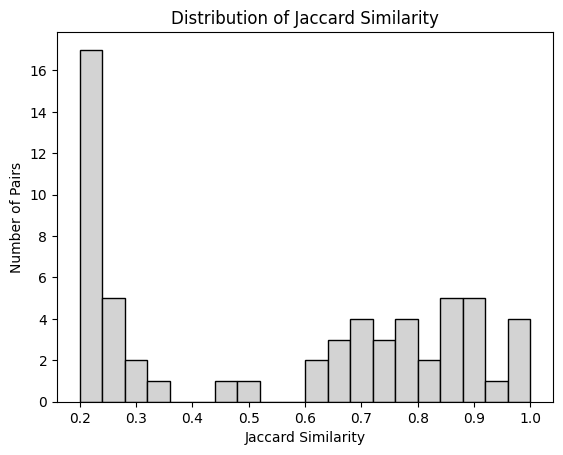

In [21]:
# Distribution of distance
import matplotlib.pyplot as plt

jaccard_values = df_002.select("jaccard").toPandas()
plt.hist(jaccard_values["jaccard"], bins=20, color='lightgrey', edgecolor='black')
plt.xlabel("Jaccard Similarity")
plt.ylabel("Number of Pairs")
plt.title("Distribution of Jaccard Similarity")
plt.show()

We see there are many documents with a comparatively less similarity ~20-30% as per Jaccard Similarity, and comparatively less documents with more similarity.

###### 4. Calculating the review lengths

In [23]:
# review length
df_002 = df_002.withColumn("lenA", length(col("review_text1"))) \
       .withColumn("lenB", length(col("review_text2")))

df_002.show()

+--------------------+----------+--------------------+--------------------+----------+--------------------+------------------+----+----+
|          review_id1|  book_id1|        review_text1|          review_id2|  book_id2|        review_text2|           jaccard|lenA|lenB|
+--------------------+----------+--------------------+--------------------+----------+--------------------+------------------+----+----+
|-1638819246228781290|B000QAANTM|"Ray Bradbury cle...| 3501372361723476771|B000NLWCE8|"_Ray Bradbury cl...|               1.0| 490| 491|
| 3445011544319591053|B000NASUVI|McBain created hi...| 3632426737699483714|B0007HSIP0|McBain created hi...|               1.0| 197| 196|
|-9194886349875442517|B000KW0GVG|Fyodor Dostoevksy...|-4627962320438149632|B000FG14OK|Fyodor Dostoevksy...|               1.0| 748| 747|
| 2989931568343160964|B000KAIZX4|THE LION THE WITC...| 7907874350738172285|B000Q382GK|THE LION THE WITC...| 0.989247311827957|1735|1734|
|-3498216980250515405|0754037746|After I 

Since we factored in at multiple steps to filter out small reviws, we see we only get similar reviews with comparatively larger length.

###### 5. Different books with identical reviws

In [24]:
# Identical Reviews for different books ?

df_002.filter((col("jaccard") >= 0.8) & (col("book_id1") != col("book_id2"))).show(truncate=150)          # Similarity > 0.8

print(f"There are {df_002.filter((col('jaccard') >= 0.8) & (col('book_id1') != col('book_id2'))).count()} book review pairs with almost identical reviews but different book IDs")

+--------------------+----------+------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------+----------+------------------------------------------------------------------------------------------------------------------------------------------------------+------------------+----+----+
|          review_id1|  book_id1|                                                                                                                                          review_text1|          review_id2|  book_id2|                                                                                                                                          review_text2|           jaccard|lenA|lenB|
+--------------------+----------+------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------+-

There are different book ids with the same reviews which introduces suspicion and also plagiarism in reviews. It also points out that there can be different bookid for same book wich are present in the dataset. And the reveiws just show redundant data (maybe sourced from different platforms), if not plagiarised.  
So we analyzed the pairs where bookids are different but reviews are similar (to filter out similar reviews for same books)  

###### 6. Similar reviews for different books

In [26]:
# Filter pairs where bookA and bookB are different
similar_across_books = df_002.filter(col("book_id1") != col("book_id2"))

similar_across_books.select(
    col("book_id1"),
    col("book_id2"),
    col("jaccard"),
    col("review_text1"),
    col("review_text2")
).orderBy(col("jaccard").desc()).limit(10).show(truncate=150)

print(f"Count of Review pairs where reviews are similar for different books, is {similar_across_books.count()}.")

+----------+----------+------------------+------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------+
|  book_id1|  book_id2|           jaccard|                                                                                                                                          review_text1|                                                                                                                                          review_text2|
+----------+----------+------------------+------------------------------------------------------------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------

###### 7. Similar books & reviews Histogram

In [27]:
# Union bookA and bookB columns to get all appearances | Book Similar Review Frequency

book_counts = df_002.select(col("book_id1").alias("book_id")) \
    .union(df.select(col("book_id2").alias("book_id"))) \
    .groupBy("book_id").count().orderBy("count", ascending=False)

book_counts.limit(15).show()

+----------+-----+
|   book_id|count|
+----------+-----+
|B000N79P10|    3|
|0380801213|    3|
|0613125355|    3|
|0786222840|    3|
|B000IEZE3G|    2|
|B000CNLIHE|    2|
|B0006DI4M2|    2|
|B0006AITE8|    2|
|B000HZ9A2W|    2|
|B000HMY3ZY|    2|
|B000GSB9M4|    1|
|B0008AIR48|    1|
|0754037746|    1|
|B000GL8UMI|    1|
|059033123X|    1|
+----------+-----+



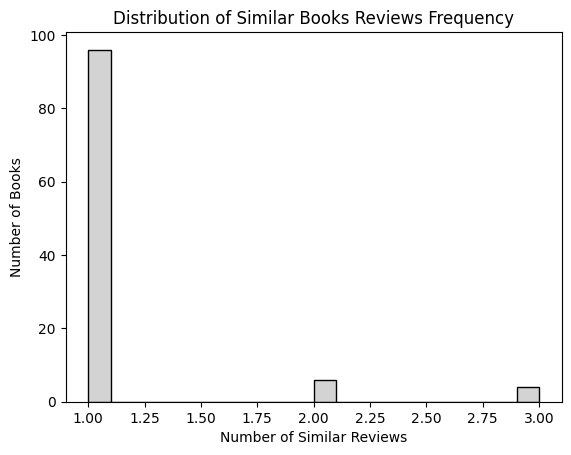

In [28]:
# Plotting the distribution
book_counts_val = book_counts.select("count").toPandas()
plt.hist(book_counts_val["count"], bins=20, color='lightgrey', edgecolor='black')
plt.xlabel("Number of Similar Reviews")
plt.ylabel("Number of Books")
plt.title("Distribution of Similar Books Reviews Frequency")
plt.show()

###### 8. Wordcloud for Common Words

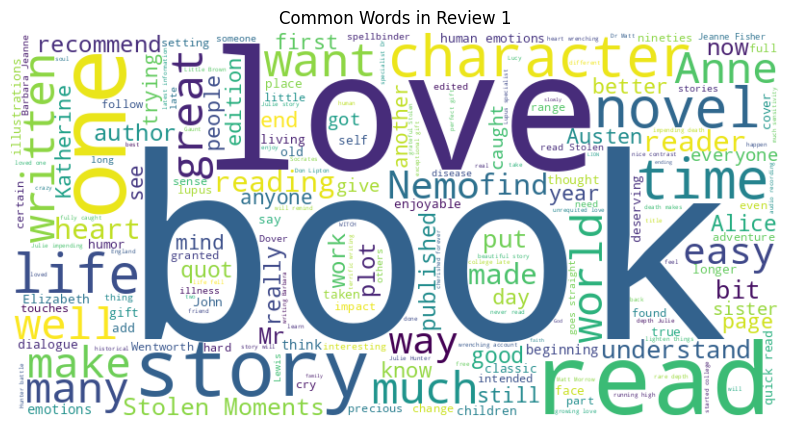

In [30]:
# Let's also create w wordcloud for these book reviews

from wordcloud import WordCloud

text = " ".join(df_002.select("review_text1").toPandas()["review_text1"].dropna().values)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Common Words in Review 1")
plt.show()

#### **End of Analysis**

In [ ]:
# ends the spark session
spark.stop()